# ✅ ISO-NE Hourly Demand Forecast — Final Results

## 📌 Executive Summary

This project builds and evaluates operational day-ahead demand forecasts for ISO-New England using publicly available hourly load data.

- **Modeling focus**: Short-term load forecasting using **lagged demand**, **calendar features**, and **weather sensitivity** via Heating & Cooling Degree Days (HDD/CDD).
- **Champion model**: **Ridge Regression (lags + calendar + HDD/CDD)**  
  → Reliable • interpretable • fast for operational use

### 🎯 Key Results  
**Test Period: July 2024 – June 2025**

| Forecast Target | Best Model Error |
|-----------------|----------------:|
| **Hourly demand (overall)** | **3.41% MAPE** *(original, non-imputed hours only)* |
| **Top-50 peak-demand hours** | **2.73% MAPE** |

> These results **significantly outperform** baseline grid forecasting methods tested here:  
> **Seasonal-Naive** (same hour yesterday) and **Holt-Winters** exponential smoothing.

### Why it matters
Better peak accuracy → fewer reserve margin surprises → improved reliability and cost control  
Fast inference → suitable for **day-ahead scheduling** and **real-time monitoring**  
Simple structure → easy to **retrain**, **tune**, and **deploy** in practice

---

### What this forecast enables
- **Grid operations**: more confident commitment and dispatch planning  
- **Market operations**: reduced volatility in bids and settlements  
- **Risk management**: better anticipation of extreme load events


## ⚙️ Load libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

## 🔧 Load Artifacts

In [2]:
ARTIFACT_DIR = "../artifacts"

y_test = pd.read_csv(f"{ARTIFACT_DIR}/y_test.csv", index_col=0, parse_dates=True)["y_test"]
test_mask = (
    pd.read_csv(f"{ARTIFACT_DIR}/test_mask.csv", index_col=0, parse_dates=True)["test_mask"]
      .astype(bool)
)
preds_fast_df = pd.read_csv(f"{ARTIFACT_DIR}/preds_fast.csv", index_col=0, parse_dates=True)

# dict[str, Series] that all later cells expect
preds_fast = {col: preds_fast_df[col] for col in preds_fast_df.columns}

print("✅ Loaded models:", list(preds_fast.keys()))
print("Test hours:", len(y_test), "| Original hours:", int((~test_mask).sum()))


✅ Loaded models: ['naive', 'snaive', 'hw_24', 'ridge_lags', 'ridge_lags_wx']
Test hours: 8588 | Original hours: 8572


## ⚙️ Metrics + score helper

In [3]:
def mape_vec(a, p):
    a, p = a.align(p, join="inner")
    return float((np.abs((a - p) / a.clip(lower=1e-6))).mean() * 100)

def rmse_vec(a, p):
    a, p = a.align(p, join="inner")
    return float(np.sqrt(((a - p)**2).mean()))

def score_series(name, y_true, y_pred, mask_original_only=True, mask=None):
    if mask_original_only:
        assert mask is not None, "Provide test_mask (True = imputed)."
        y_true = y_true[~mask]
        y_pred = y_pred.reindex(y_true.index)
    return pd.Series({"RMSE": rmse_vec(y_true, y_pred),
                      "MAPE": mape_vec(y_true, y_pred)}, name=name)


## ✅ Final Results Table

In [4]:
rows = []
for name, pred in preds_fast.items():
    rows.append(score_series(name, y_test, pred, mask_original_only=True, mask=test_mask))
results = pd.DataFrame(rows).sort_values("MAPE").round(3)
results["MAPE"] = results["MAPE"].map(lambda x: f"{x:.2f}%")
results

,RMSE,MAPE
ridge_lags_wx,548.499,3.41%
ridge_lags,560.613,3.47%
snaive,1937.499,10.48%
naive,3282.550,24.04%
hw_24,3360.142,24.12%


In [5]:
best = results.loc["ridge_lags_wx" if "ridge_lags_wx" in results.index else "ridge_lags"]
snaive = results.loc["snaive"]

d_mape = float(str(snaive["MAPE"]).rstrip('%')) - float(str(best["MAPE"]).rstrip('%'))
pct_mape = d_mape / float(str(snaive["MAPE"]).rstrip('%')) * 100

d_rmse = float(str(snaive["RMSE"]).rstrip('%')) - float(str(best["RMSE"]).rstrip('%'))
pct_rmse = d_rmse / float(str(snaive["RMSE"]).rstrip('%')) * 100

print(f"Δ MAPE for Ridge Lag-Wx vs Seasonal-Naive: {d_mape:.2f} pts ({pct_mape:.1f}% reduction)")
print(f"Δ RMSE for Ridge Lag-Wx vs Seasonal-Naive: {d_rmse:,.0f} MW ({pct_rmse:.1f}% reduction)")

Δ MAPE for Ridge Lag-Wx vs Seasonal-Naive: 7.07 pts (67.5% reduction)
Δ RMSE for Ridge Lag-Wx vs Seasonal-Naive: 1,389 MW (71.7% reduction)


### **Result:** Ridge reduces error by **ΔMAPE 7 pts (~68%)** and **ΔRMSE 1389 MW (~72%)** vs. Seasonal-Naive.

## 📌 Monthly MAPE comparison between Ridge (baseline) and Ridge (CDD/HDD)

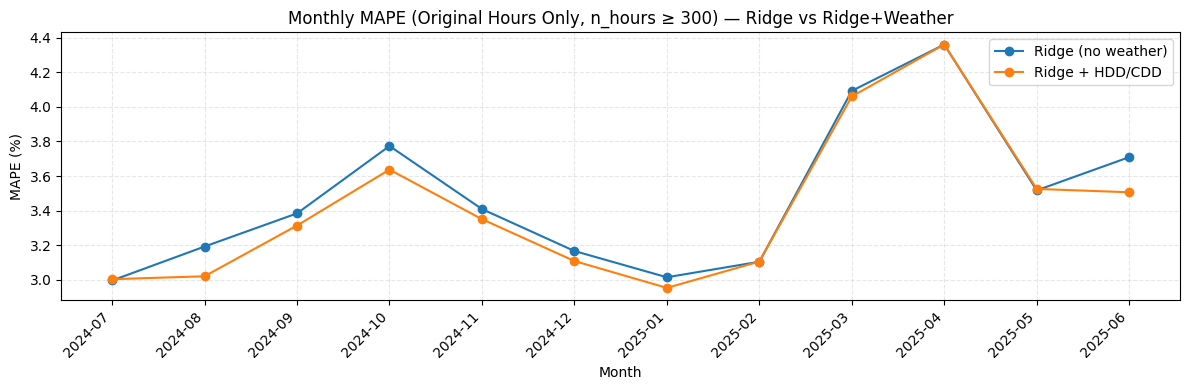

,MAPE_no_wx,MAPE_with_wx,n_hours,Delta (with_wx - no_wx)
month,,,,
2024-07,2.995%,3.003%,744,0.007%
2024-08,3.192%,3.020%,744,-0.172%
2024-09,3.384%,3.314%,720,-0.070%
2024-10,3.774%,3.637%,744,-0.137%
2024-11,3.409%,3.350%,719,-0.058%
2024-12,3.166%,3.108%,744,-0.058%
2025-01,3.014%,2.953%,741,-0.062%
2025-02,3.104%,3.105%,671,0.001%
2025-03,4.093%,4.060%,743,-0.032%


In [6]:

MIN_HOURS = 300  # require at least ~2 weeks of original hours per month

actual_o   = y_test[~test_mask]
pred_no_wx = preds_fast.get("ridge_lags", pd.Series(dtype=float)).reindex(actual_o.index)
pred_wx    = preds_fast.get("ridge_lags_wx", pd.Series(dtype=float)).reindex(actual_o.index)

monthly = (
    pd.DataFrame({"actual": actual_o, "no_wx": pred_no_wx, "with_wx": pred_wx})
      .dropna(subset=["no_wx"])
      .assign(month=lambda df: df.index.to_period("M"))
      .groupby("month", observed=True)
      .agg(
          MAPE_no_wx = ("actual", lambda a: mape_vec(a, pred_no_wx.loc[a.index])),
          MAPE_with_wx = ("actual", lambda a: mape_vec(a, pred_wx.loc[a.index])),
          n_hours = ("actual", "size"),
      )
      .sort_index()
)
monthly["n_hours"] = monthly["n_hours"].astype(int)

monthly_f = monthly.query("n_hours >= @MIN_HOURS").copy()
monthly_f["Delta (with_wx - no_wx)"] = (monthly_f["MAPE_with_wx"] - monthly_f["MAPE_no_wx"]).round(3)

plt.figure(figsize=(12,4))
plt.plot(monthly_f.index.astype(str), monthly_f["MAPE_no_wx"],  marker="o", label="Ridge (no weather)")
plt.plot(monthly_f.index.astype(str), monthly_f["MAPE_with_wx"], marker="o", label="Ridge + HDD/CDD")
plt.title(f"Monthly MAPE (Original Hours Only, n_hours ≥ {MIN_HOURS}) — Ridge vs Ridge+Weather")
plt.ylabel("MAPE (%)"); plt.xlabel("Month")
plt.grid(alpha=0.3, linestyle="--")
plt.xticks(rotation=45, ha="right"); plt.legend()
plt.tight_layout(); plt.show()

cols_to_format = [
    "MAPE_with_wx",
    "MAPE_no_wx",
    "Delta (with_wx - no_wx)",
]

for col in cols_to_format:
    monthly_f[col] = monthly_f[col].map(lambda x: f"{x:.3f}%")

monthly_f.round(3)

## ☀️ June 2025 test days — best model (Ridge with CDD) vs Actual

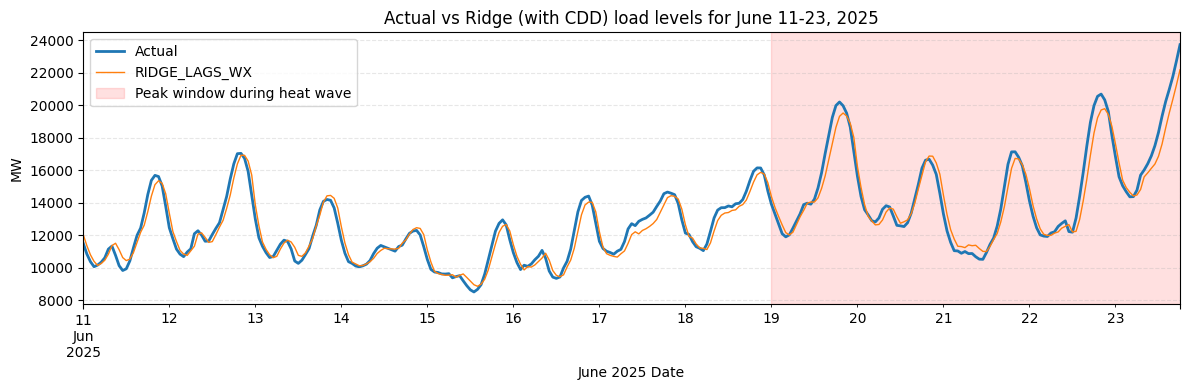

In [7]:
best_key = "ridge_lags_wx" if "ridge_lags_wx" in preds_fast else "ridge_lags"
pred_best = preds_fast[best_key].reindex(y_test.index)

first = slice(24*345, 8587)
ax = y_test.iloc[24*345:8587].plot(figsize=(12,4), label="Actual", lw=2)
pred_best.iloc[24*345:8587].plot(ax=ax, label=best_key.upper(), lw=1)
#Visible heatwave
ax.axvspan(y_test.index[24*353], y_test.index[8587], color="red", alpha=0.12, label="Peak window during heat wave")
plt.title("Actual vs Ridge (with CDD) load levels for June 11-23, 2025")
plt.xlabel("June 2025 Date")
plt.ylabel("MW")
plt.legend(); plt.grid(alpha=0.3, ls="--"); plt.tight_layout(); plt.show()

### 🔋 Peak-Hour Stress Test — Top 50 Highest-Demand Hours

Grid operators care most about performance during **times of high demand**:
heat waves, cold snaps, or times of high economic demand.

The above plot shows the actual and Ridge (CDD included) data for mid to late June 2025. Unfortunately, the data ended in the middle of a significant northeast heatwave in June 2025, but we managed to capture the rising load in the middle of this hot spell. The daily load soared, and while the Ridge model deviated slightly more than usual from the actual load levels, its forecast was still within 5-7% of the actual load.

Therefore, we now decided to test the **50 highest-load hours** in the test period and
compare our model’s prediction error only on those moments — where getting the
forecast wrong has the **largest operational cost**. Several of those highest-load hours occurred during the June 2025 heat wave.

**Why this matters**
- Peak hours drive **reserve deployments** and **real-time market volatility**
- Errors here are far more expensive than on typical hours
- Good peak tracking = better reliability + lower balancing cost

We compute **APE (Absolute Percentage Error)** for each peak hour and report the average:

 > **Top-50 Peak-Hour MAPE:** *2.72%*  

✅ Result: The model maintains strong performance even under **extreme demand** conditions, making it a strong choice for operational forecasting. In fact, for the plot below where high errors were emphasized, the model was so effective that errors of 5-6% were near the high end.

In [8]:
peak_idx = y_test.nlargest(50).index
dfp = pd.DataFrame({
    "actual": y_test.loc[peak_idx],
    "pred": pred_best.loc[peak_idx]
}).assign(APE=lambda d: (d["actual"]-d["pred"]).abs()/d["actual"]*100)
print("Top-50 peak-hour MAPE:", dfp["APE"].mean().round(2), "%")

Top-50 peak-hour MAPE: 2.72 %


## 🔧 Top 50 Peak Hours Dot Plot: Actual vs Predicted (chronological order)
### This includes row highlights for APE > 5% (red 🔴) and APE < 1% (green 🟢)

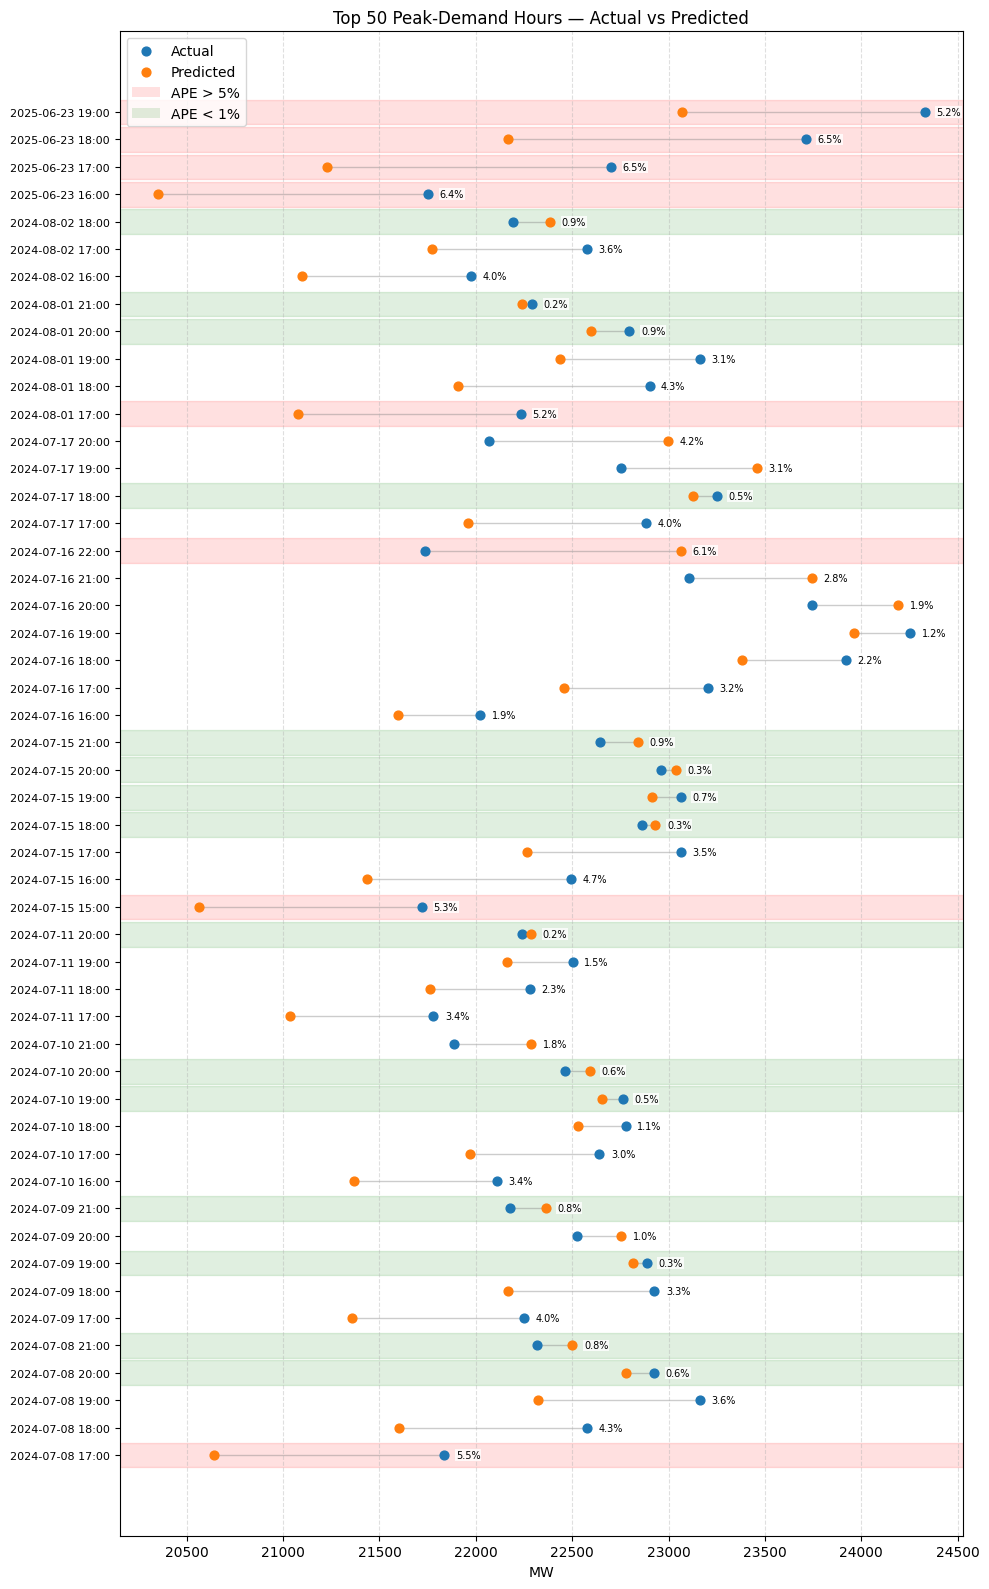

In [9]:
# Sort chronologically
dfp_sorted = dfp.sort_index()

# Categorical y positions (even spacing; not to scale)
y_labels = dfp_sorted.index.strftime("%Y-%m-%d %H:%M")
y_pos = np.arange(len(dfp_sorted))

# Thresholds
HI = 5.0   # percent
LO = 1.0

hi_mask = dfp_sorted["APE"] > HI
lo_mask = dfp_sorted["APE"] < LO

fig, ax = plt.subplots(figsize=(10, 16))

# 1) Background row highlights first (so dots/lines appear on top)
band_half = 0.45  # thickness of each row band
for i in range(len(dfp_sorted)):
    if hi_mask.iloc[i]:
        ax.axhspan(y_pos[i] - band_half, y_pos[i] + band_half, color="red",   alpha=0.12, zorder=0)
    elif lo_mask.iloc[i]:
        ax.axhspan(y_pos[i] - band_half, y_pos[i] + band_half, color="green", alpha=0.12, zorder=0)

# 2) Connector lines (error magnitude)
for i in range(len(dfp_sorted)):
    ax.plot(
        [dfp_sorted["actual"].iloc[i], dfp_sorted["pred"].iloc[i]],
        [y_pos[i], y_pos[i]],
        color="gray", alpha=0.4, linewidth=1, zorder=1
    )

# 3) Points
ax.scatter(dfp_sorted["actual"], y_pos, label="Actual", s=40, zorder=2)
ax.scatter(dfp_sorted["pred"],   y_pos, label="Predicted", s=40, zorder=2)

# Axes & labels
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels, fontsize=8)
ax.set_xlabel("MW")
ax.set_title("Top 50 Peak-Demand Hours — Actual vs Predicted")

ax.grid(axis="x", linestyle="--", alpha=0.4)

# Label each point with APE (%)
# dynamic offsets (1.5% of x-range)
x_range = dfp_sorted[["actual", "pred"]].values.ptp()
x_offset = x_range * 0.015  

for i, (a, p, ape) in enumerate(
        zip(dfp_sorted["actual"], dfp_sorted["pred"], dfp_sorted["APE"])
    ):

    # determine direction: if model underpredicted, put label right of pred
    if p < a:
        x_text = a + x_offset
        ha = "left"
    else:  # model overpredicted
        x_text = p + x_offset
        ha = "left"

    ax.text(
        x_text,
        y_pos[i],
        f"{ape:.1f}%",
        va="center",
        ha=ha,
        fontsize=7,
        color="black",
        weight= "normal",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=0.6),
        zorder=3,
    )

# Legend: add patches to explain highlights
legend_items = [
    Patch(facecolor="red",   alpha=0.12, label=f"APE > {HI:.0f}%"),
    Patch(facecolor="green", alpha=0.12, label=f"APE < {LO:.0f}%")
]
ax.legend(handles=[*ax.get_legend_handles_labels()[0], *legend_items], loc="best")

plt.tight_layout()
plt.show()

## Leaderboard — Original (non-imputed) test hours

- **Naive** → Too sticky and shows zero variation - but this is the baseline with which to compare other models
- **Seasonal-Naive** → Reasonable daily cycle but misses anomalous patterns  
- **Holt-Winters** → Captures basic daily structure but shows no day-to-day variation
- **Ridge (lags + HDD/CDD)** → Best overall accuracy and peak tracking ✅


## 🔍 Key Findings

- **Accuracy:** Final model achieves **3.41% MAPE** on **original (non-imputed)** test hours (July 2024–June 2025).
- **Weather helps:** Adding **HDD/CDD** reduces error during seasonal extremes (winter/summer) without hurting stable months.
- **Transparent evaluation:** Metrics exclude imputed hours and enforce a minimum-hours threshold per month to avoid misleading spikes.

## 🌟 Business Impact

Better forecasts = measurable gains:

| Benefit | Impact |
|--------|--------|
| Improved day-ahead scheduling | Avoids expensive reserve procurement when demand is high|
| Fewer imbalance fees | Savings for market participants |
| Operational resilience | Maintains reliability during demand spikes |

---

## ✅ Conclusion

We successfully developed a practical electric-load forecasting model for ISO-NE using a fully transparent and defensible analytics workflow:

- A **robust data-cleaning process** repaired multi-day stretches of missing data using season-aware techniques

- A fast, interpretable **Ridge regression model** (lags + calendar features + HDD/CDD) delivered the best overall performance

- Achieved **3.41% MAPE** on original (non-imputed) test hours — strong accuracy for operational short-term forecasting

- Errors remained **stable across seasons** and **well-contained during high-demand peaks**

## 🔭 Future Work

The model is accurate, computationally efficient, and **deployment-ready** for grid-operations use cases — while providing a solid foundation for these possible future enhancements, which could increase accuracy and real-world value:

| Enhancement | Benefit |
|------------|---------|
| **Use weather forecasts** instead of historical weather | Improves performance during heatwaves and cold snaps |
| **Test stronger ML models** (XGBoost, LSTMs, N-BEATS) | Potentially improves peak-hour accuracy |
| **Account for electrification trends** (EVs, heat pumps) | Supports medium-term planning decisions |
| **Model AI data center load growth** | High-growth segment that can reshape regional peaks |
| **Add uncertainty estimates** (prediction intervals) | Supports reserve margins and risk-aware grid operations |

This creates a roadmap from a strong baseline today to a model that stays aligned with the **future of New England’s grid**.

## 💾 Save outputs

In [10]:
import os
EXPORT_DIR = "../artifacts"; os.makedirs(EXPORT_DIR, exist_ok=True)
results.to_csv(f"{EXPORT_DIR}/final_results_table.csv")
monthly_f.to_csv(f"{EXPORT_DIR}/monthly_mape_compare.csv")
print("Saved:", os.listdir(EXPORT_DIR))

Saved: ['test_mask.parquet', 'preds_fast.csv', 'monthly_mape_compare.csv', 'y_test.parquet', 'test_mask.csv', 'preds_fast.parquet', 'y_test.csv', 'final_results_table.csv']


**Reproduce**
1) Run `01_data_prep.ipynb` → saves `isone_demand_clean.csv`
2) Run `02_modeling.ipynb` → saves artifacts to `../artifacts/`
3) Run `03_final_results.ipynb` (this notebook)